In [3]:
import sys
import os

# Get the current working directory
current_dir = os.getcwd()

# Get the parent directory
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))

# Add the parent directory to sys.path
sys.path.append(parent_dir)

In [4]:
import numpy as np
import time
import torch
import torch.nn as nn
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from diffusers.schedulers.scheduling_ddpm import DDPMScheduler
from diffusers.training_utils import EMAModel
from diffusers.optimization import get_scheduler
from tqdm.auto import tqdm
import submodules.data_filter as _df
import diffusion_pipline.data_processing as dproc
import diffusion_pipline.model as md
import submodules.cleaned_file_parser as cfp


In [5]:
# observation and action dimensions corrsponding to
# the output of PushTEnv
# obs_dim = 25
# action_dim = 13
type = 'SSSS'
obs_dim = 45
action_dim = 12
# parameters
pred_horizon = 16
obs_horizon = 2
action_horizon = 8
target_fps = 120.0

action_item = ['chisel', 'gripper']
obs_item = ['battery']

# create network object
noise_pred_net = md.ConditionalUnet1D(
    input_dim=action_dim,
    global_cond_dim=obs_dim*obs_horizon
)

# example inputs
noised_action = torch.randn((1, pred_horizon, action_dim))
obs = torch.zeros((1, obs_horizon, obs_dim))
diffusion_iter = torch.zeros((1,))

# the noise prediction network
# takes noisy action, diffusion iteration and observation as input
# predicts the noise added to action
noise = noise_pred_net(
    sample=noised_action,
    timestep=diffusion_iter,
    global_cond=obs.flatten(start_dim=1))

# illustration of removing noise
# the actual noise removal is performed by NoiseScheduler
# and is dependent on the diffusion noise schedule
denoised_action = noised_action - noise

# for this demo, we use DDPMScheduler with 100 diffusion iterations
num_diffusion_iters = 100
noise_scheduler = DDPMScheduler(
    num_train_timesteps=num_diffusion_iters,
    # the choise of beta schedule has big impact on performance
    # we found squared cosine works the best
    beta_schedule='squaredcos_cap_v2',
    # clip output to [-1,1] to improve stability
    clip_sample=True,
    # our network predicts noise (instead of denoised action)
    prediction_type='epsilon'
)

# device transfer
device = torch.device('cuda')
_ = noise_pred_net.to(device)

number of parameters: 6.651803e+07


In [6]:
# create dataset from file
# path_name = "/home/cam/Downloads/Supporting Data - Sheet1.csv"
base_path = "/home/cam/Documents/diffusion_policy_cam/no_sync/data_chisel_task/offset_interpolated_training_traj/"

# Load data
dict_of_df_rigid = {}
dict_of_df_marker = {}


for file in os.listdir(base_path):
    if file.endswith(".csv") and file.startswith("cap"):
        path_name = base_path + file
        data = cfp.DataParser.from_euler_file(file_path = path_name, target_fps=target_fps, filter=False, window_size=15, polyorder=3)
        dict_of_df_marker[file] = data.get_marker_Txyz()
        dict_of_df_rigid[file] = data.get_rigid_TxyzRxyz()

item_name = data.rigid_bodies
marker_name = data.markers

if len(dict_of_df_rigid) == len(dict_of_df_marker):

    rigiddataset, index = _df.episode_combiner(dict_of_df_rigid, item_name)
    markerdataset, _ = _df.episode_combiner(dict_of_df_marker, marker_name)
    print(index[action_item[0]])


#### if you don't want battery info then just do obs_item = None abd also do clear all outputs and restart the kernal before that and satrt from the top 

dataset = dproc.TaskStateDataset(rigiddataset, markerdataset, index[action_item[0]], 
                                 action_item = action_item, obs_item = obs_item,
                                 marker_item= marker_name,
                                 pred_horizon=pred_horizon,
                                 obs_horizon=obs_horizon,
                                 action_horizon=action_horizon)

# create dataloader
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=256,
    num_workers=1,
    shuffle=True,
    # accelerate cpu-gpu transfer
    pin_memory=True,
    # don't kill worker process afte each epoch
    persistent_workers=True
)

batch = next(iter(dataloader))
print("batch['obs'].shape:", batch['obs'].shape)
print("batch['action'].shape", batch['action'].shape)

[1091, 2311, 3709, 4610, 5625, 7276, 8217, 9432, 10375, 11051, 12238, 13080, 14128, 15653, 16672, 17688, 18711, 20020, 20850, 21796, 22630, 23808, 24772, 25602, 27050, 28162, 28989, 29771, 30604, 32360, 33565, 34729, 35681, 36922, 37935, 38962, 40354, 41732, 42745, 43885, 45427, 46300, 47266, 48142, 49109, 49949, 50856, 52294, 53956, 54910, 56941, 57987, 59047, 59974, 60826, 62174, 63143, 64372, 65268, 67562, 68647, 69785, 70636, 71567, 72720, 73814, 74683, 75655, 77090, 78011, 78933, 80357, 81221, 82254, 83135, 84087, 85044, 86070, 86838, 87765, 88698, 89723, 90583, 91511, 92409, 93677, 94922, 95702, 96644, 97929, 99112, 100195, 101460, 102605, 103949, 104800, 105766, 106950, 107766, 108788, 109960, 110659, 111638, 113215, 114206, 115154, 116066, 117043, 118373, 119269, 120146, 121354, 122251, 123122, 124102, 125257, 126823, 127734, 128603]
batch['obs'].shape: torch.Size([256, 2, 45])
batch['action'].shape torch.Size([256, 16, 12])


In [7]:
#@markdown ### **Training**
#@markdown
#@markdown Takes about an hour. If you don't want to wait, skip to the next cell
#@markdown to load pre-trained weights

num_epochs =200
checkpoint_dir = 'checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_interval = 3600
last_checkpoint_time = time.time()
# Exponential Moving Average
# accelerates training and improves stability
# holds a copy of the model weights
ema = EMAModel(
    parameters=noise_pred_net.parameters(),
    power=0.75)

# Standard ADAM optimizer
# Note that EMA parametesr are not optimized
optimizer = torch.optim.AdamW(
    params=noise_pred_net.parameters(),
    lr=1e-4, weight_decay=1e-6)

# Cosine LR schedule with linear warmup
lr_scheduler = get_scheduler(
    name='cosine',
    optimizer=optimizer,
    num_warmup_steps=200,
    num_training_steps=len(dataloader) * num_epochs
)

with tqdm(range(num_epochs), desc='Epoch') as tglobal:
    # epoch loop
    epoch_loss = []
    batch_loss_per_epoch = []

    for epoch_idx in tglobal:
        batch_loss = []
        batch_noise = []
        # batch loop
        with tqdm(dataloader, desc='Batch', leave=False) as tepoch:

            for nbatch in tepoch:
                # data normalized in dataset
                # device transfer
                nobs = nbatch['obs']
                naction = nbatch['action']
                B = nobs.shape[0]

                # observation as FiLM conditioning
                # (B, obs_horizon, obs_dim)
                obs_cond = nobs[:,:obs_horizon,:]
                # (B, obs_horizon * obs_dim)
                obs_cond = obs_cond.flatten(start_dim=1).float().to(device)
                # print(obs_cond.type())

                # sample noise to add to actions
                # noise = torch.randn(naction.shape, device=device)
                noise = torch.randn(naction.shape)

                # sample a diffusion iteration for each data point
                timesteps = torch.randint(
                    0, noise_scheduler.config.num_train_timesteps,
                    (B,)
                ).long()

                # add noise to the clean images according to the noise magnitude at each diffusion iteration
                # (this is the forward diffusion process)
                noisy_actions = noise_scheduler.add_noise(
                    naction, noise, timesteps)
                
                noise = noise.to(device)
                
                timesteps = timesteps.to(device)

                # print(noisy_actions.type())
                noisy_actions = noisy_actions.type(torch.FloatTensor).to(device)
                # print(noisy_actions.type())

                # predict the noise residual
                noise_pred = noise_pred_net(
                    noisy_actions, timesteps, global_cond=obs_cond)
                
                batch_noise.append(noise_pred)

                # L2 loss
                loss = nn.functional.mse_loss(noise_pred, noise)

                # optimize
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                # step lr scheduler every batch
                # this is different from standard pytorch behavior
                lr_scheduler.step()

                # update Exponential Moving Average of the model weights
                ema.step(noise_pred_net)
                # print(ema.state_dict)

                # logging
                loss_cpu = loss.item()
                batch_loss.append(loss_cpu)
                tepoch.set_postfix(loss=loss_cpu)

        # save checkpoint
        # went to the emma model library and added state_dict to the model
        current_time = time.time()
        if current_time - last_checkpoint_time > checkpoint_interval:
            checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_{type}_epoch_{epoch_idx}.pth')
            torch.save({
                        'epoch': epoch_idx,
                        'model_state_dict': noise_pred_net.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'scheduler_state_dict': lr_scheduler.state_dict(),
                        'ema_state_dict': ema.state_dict(),
                        'len_dataloader': len(dataloader),
                        'dataset_stats': dataset.stats,
                        'num_epochs': num_epochs,
                        'obs_dim': obs_dim,
                        'action_dim': action_dim,
                        'pred_horizon': pred_horizon,
                        'obs_horizon': obs_horizon,
                        'action_horizon': action_horizon,
                        'target_fps': target_fps,
                        'action_item': action_item,
                        'obs_item': obs_item,
                        'marker_item': marker_name,
                    }, checkpoint_path)
            last_checkpoint_time = current_time
            
        tglobal.set_postfix(loss=np.mean(batch_loss))
        epoch_loss.append(np.mean(batch_loss))
        batch_loss_per_epoch.append(batch_loss)

# Weights of the EMA model
# is used for inference
ema_noise_pred_net = noise_pred_net

checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_{type}_epoch_{epoch_idx}.pth')
torch.save({
    'epoch': epoch_idx,
    'model_state_dict': noise_pred_net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': lr_scheduler.state_dict(),
    'ema_state_dict': ema.state_dict(),
    'len_dataloader': len(dataloader),
    'dataset_stats': dataset.stats,
    'num_epochs': num_epochs,
    'obs_dim': obs_dim,
    'action_dim': action_dim,
    'pred_horizon': pred_horizon,
    'obs_horizon': obs_horizon,
    'action_horizon': action_horizon,
    'target_fps': target_fps,
    'action_item': action_item,
    'obs_item': obs_item,
    'marker_item': marker_name,
}, checkpoint_path)
print(f'Checkpoint saved at epoch {epoch_idx}')

Epoch:  18%|█▊        | 37/200 [1:01:44<4:49:22, 106.52s/it, loss=0.00438]

Checkpoint saved at epoch 36


Epoch:  36%|███▌      | 71/200 [2:02:00<3:49:02, 106.53s/it, loss=0.00294]

Checkpoint saved at epoch 70


Epoch:  52%|█████▎    | 105/200 [3:02:17<2:48:39, 106.52s/it, loss=0.00203]

Checkpoint saved at epoch 104


Epoch:  70%|██████▉   | 139/200 [4:02:34<1:48:18, 106.53s/it, loss=0.00134]

Checkpoint saved at epoch 138


Epoch:  86%|████████▋ | 173/200 [5:02:50<47:56, 106.52s/it, loss=0.000912]  

Checkpoint saved at epoch 172


Epoch: 100%|██████████| 200/200 [5:50:41<00:00, 105.21s/it, loss=0.000821]


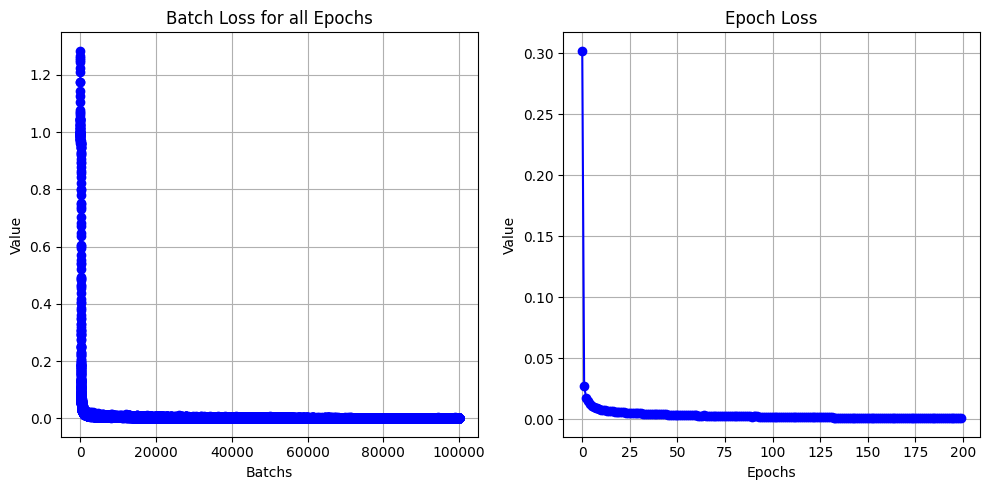

In [8]:
# Create a figure and axis
import matplotlib.pyplot as plt

flatten_loss = np.array(batch_loss_per_epoch)

flatten_loss = flatten_loss.flatten()
# Define subplots correctly
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot for the first subplot (ax1)
ax1.plot(flatten_loss, marker='o', linestyle='-', color='b', label='Values')

# Customize the first subplot (ax1)
ax1.set_xlabel('Batchs')
ax1.set_ylabel('Value')
ax1.set_title('Batch Loss for all Epochs')
ax1.grid(True)
# ax1.legend()

# Plot for the second subplot (ax2)
ax2.plot(epoch_loss, marker='o', linestyle='-', color='b', label='Values')

# Customize the second subplot (ax2)
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Value')
ax2.set_title('Epoch Loss')
ax2.grid(True)
# ax2.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

####  CHANGED WAY

In [10]:
# create dataset from file
# path_name = "/home/cam/Downloads/Supporting Data - Sheet1.csv"
base_path = "/home/cam/Documents/diffusion_policy_cam/no_sync/data_chisel_task/offset_interpolated_test_traj/"

# Load data
dict_of_df_rigid_test = {}
dict_of_df_marker_test = {}
name = []

# for file in os.listdir(base_path):
#     name.append(file)
for file in os.listdir(base_path):
    if file.endswith(".csv"):
        name.append(file)
        path_name = base_path + file
        data_test = cfp.DataParser.from_euler_file(file_path = path_name, target_fps=target_fps, filter=True, window_size=15, polyorder=3)

        dict_of_df_marker_test[file] = data_test.get_marker_Txyz()
        dict_of_df_rigid_test[file] = data_test.get_rigid_TxyzRxyz()


item_name_test = data_test.rigid_bodies
marker_name_test = data_test.markers

if len(dict_of_df_rigid_test) == len(dict_of_df_marker_test):

    rigiddataset_test, index_test = _df.episode_combiner(dict_of_df_rigid_test, item_name_test)
    markerdataset_test, _ = _df.episode_combiner(dict_of_df_marker_test, marker_name_test)

indexes = index_test[action_item[0]]
action = []
obs = []
for i in range(indexes[-1]):
    # a = []
    a = np.concatenate([rigiddataset_test[item][i] for item in action_item])
    # print(a)

    b = np.concatenate([rigiddataset_test[item][i] for item in action_item] + [rigiddataset_test[item][i] for item in obs_item] + [markerdataset_test[item][i] for item in marker_name_test])
    # print(b)
    
    action.append(a)
    obs.append(b)
    
# All demonstration episodes are concatinated in the first dimension N
action = np.array(action, dtype=np.float64)
obs = np.array(obs, dtype=np.float64)

# Initialize lists to store segmented data
splits_obs = []
splits_action = []
previous_index = 0

# Iterate through episode_ends and slice action and obs accordingly
for index in indexes:
    splits_obs.append(obs[previous_index:index + 1])  # Include index itself in the slice
    splits_action.append(action[previous_index:index + 1])
    previous_index = index + 1

In [13]:
len(splits_obs[0][0])

45

In [14]:
import collections

trajectories = {}
losses_per_traj = {}
for j in range(len(episode_ends)):
    # print(j)
    # get first observation
    com_obs = splits_obs[j]
    obs = splits_obs[j][0]
    actions_test = splits_action[j]
    # max_steps = len(test_data['action'])
    max_steps = len(actions_test)
    stats = dataset.stats
    # keep a queue of last 2 steps of observations
    obs_deque = collections.deque(
        [obs] * obs_horizon, maxlen=obs_horizon)

    # save visualization and rewards
    done = False
    step_idx = 0
    traj = []
    loss_com = []
    with tqdm(total=max_steps, desc="Eval") as pbar:
        while not done:
            B = 1
            # stack the last obs_horizon (2) number of observations
            obs_seq = np.stack(obs_deque)
            # print("Obs_sep -",obs_seq)
            # normalize observation
            nobs = dproc.normalize_data(obs_seq, stats=stats['obs'])
            # print(nobs)
            # device transfer
            nobs = torch.from_numpy(nobs).to(device, dtype=torch.float32)
            # infer action
            with torch.no_grad():
                # reshape observation to (B,obs_horizon*obs_dim)
                obs_cond = nobs.unsqueeze(0).flatten(start_dim=1)
                # print(obs_cond.shape)

                # initialize action from Guassian noise
                noisy_action = torch.randn(
                    (B, pred_horizon, action_dim), device=device)
                naction = noisy_action

                # init scheduler
                noise_scheduler.set_timesteps(num_diffusion_iters)

                for k in noise_scheduler.timesteps:
                    # predict noise
                    noise_pred = ema_noise_pred_net(
                        sample=naction,
                        timestep=k,
                        global_cond=obs_cond
                    )

                    # inverse diffusion step (remove noise)
                    naction = noise_scheduler.step(
                        model_output=noise_pred,
                        timestep=k,
                        sample=naction
                    ).prev_sample

            # unnormalize action
            naction = naction.detach().to('cpu').numpy()
            # (B, pred_horizon, action_dim)
            # print(len(naction[0]))
            naction = naction[0]
            action_pred = dproc.unnormalize_data(naction, stats=stats['action'])

            # only take action_horizon number of actions
            start = obs_horizon - 1
            end = start + action_horizon
            action = action_pred[start:end,:]
            traj.extend(action)
            losses = []
                
            for i in range(len(action)):
                # loss
            # print("Action_pred -",action[0])
            # print("Action_orignal -",actions_test[0])
            # print("Obs_added without pred-",com_obs[i])
                if len(action) > len(actions_test):
                    done = True
                if done:
                    break
                loss_test = nn.functional.mse_loss(torch.tensor(action[i]), torch.tensor(actions_test[i]))
                action_last = list(action[i])
                # print("Action_last ---",action_last)
                com_obs_part = list(com_obs[i][12:])
                # print("Obs to add", com_obs_part)
                # Concatenating prediction to the obs lists
                com_obs[i] = action_last + com_obs_part
                # print("Obs_added with pred -",com_obs[i])
                obs_deque.append(com_obs[i])
                losses.append(loss_test.item())
                # update progress bar
                step_idx += 1
                pbar.update(1)
                pbar.set_postfix(loss=np.mean(losses))
                # print(i)
                if step_idx > max_steps:
                    done = True
                if done:
                    break
            com_obs = com_obs[len(action):]
            actions_test = actions_test[len(action):]
            # com_obs = com_obs[1:]
            # actions_test = actions_test[1:]
            loss_com.append(np.mean(losses).tolist())
    losses_per_traj[f"{name[j]}"] = np.nanmean(loss_com)
    trajectories[f"{name[j]}"] = traj

Eval: 100%|█████████▉| 928/932 [01:52<00:00,  8.23it/s, loss=0.0552]


In [15]:
import csv


for index, key in enumerate(trajectories.keys()):
    print(index)
    # Define the file path or name
    file_path = f'/home/cam/Documents/diffusion_policy_cam/no_sync/pred_comparison_july_22/pred_correct_method_state_chisel_gripper_battery_marker/pred_{key}'

    save_type='EULER'
    # add first rows
    _params = {
        'QUAT': {'len':7,
                    'dof': ['X', 'Y', 'Z', 'w', 'x', 'y', 'z']},
        'EULER': {'len':6,
                    'dof': ['X', 'Y', 'Z', 'x', 'y', 'z']}
    }
    
    _SUP_HEADER_ROW = (["RigidBody"] * len(data.rigid_bodies) * _params[save_type]['len'] + ["Marker"] * len(data.markers) * 3)
    _FPS_ROW = ["FPS", target_fps] + [0.0]*(len(_SUP_HEADER_ROW) - 2)
    _rb_col_names = [f"{rb}_{axis}" for rb in action_item for axis in _params[save_type]['dof']]
    _obs_col_name = [f"{rb}_{axis}" for rb in obs_item for axis in _params[save_type]['dof']]
    _mk_col_names = [f"{mk}_{axis}" for mk in marker_name for axis in ['X', 'Y', 'Z']]
    _HEADER_ROW = _rb_col_names + _obs_col_name + _mk_col_names
    print(len(trajectories[key]))
    print(len(splits_obs[index]))
    min_length = min(len(trajectories[key]), len(splits_obs[index][11:]))


    # Combine up to the minimum length
    combined_list = [np.concatenate([x, y[12:]])  for x, y in zip(np.array(trajectories[key][:min_length]), np.array(splits_obs[index][:min_length]))]

    
    # Open the file in write mode
    with open(file_path, 'w') as file:
        writer = csv.writer(file)
        writer.writerow(_SUP_HEADER_ROW)
        writer.writerow(_FPS_ROW)
        writer.writerow(_HEADER_ROW)
        writer.writerows(combined_list)

0
848
846
1
840
835
2
1000
994
3
864
856
4
808
803
5
1264
1262
6
792
788
7
944
940
8
1080
1076
9
896
893
10
1040
1032
11
1032
1030
12
1072
1064
13
896
893
14
920
918
15
1256
1251
16
1064
1061
17
944
943
18
984
977
19
1104
1098
20
936
935
21
848
847
22
808
800
23
936
932


#### Training evaluation

In [22]:
# create dataset from file
# path_name = "/home/cam/Downloads/Supporting Data - Sheet1.csv"
base_path = "no_sync/data_chisel_task/2-cleaned_interpolation_with_offset/offset_interpolated_training_traj/"

# Load data
dict_of_df_rigid_test = {}
dict_of_df_marker_test = {}
name = []

# for file in os.listdir(base_path):
#     name.append(file)
for file in os.listdir(base_path):
    if file.endswith(".csv"):
        name.append(file)
        path_name = base_path + file
        data_test = cfp.DataParser.from_euler_file(file_path = path_name, target_fps=target_fps, filter=True, window_size=15, polyorder=3)

        dict_of_df_marker_test[file] = data_test.get_marker_Txyz()
        dict_of_df_rigid_test[file] = data_test.get_rigid_TxyzRxyz()


item_name_test = data_test.rigid_bodies
marker_name_test = data_test.markers

if len(dict_of_df_rigid_test) == len(dict_of_df_marker_test):

    rigiddataset_test, index_test = _df.episode_combiner(dict_of_df_rigid_test, item_name_test)
    markerdataset_test, _ = _df.episode_combiner(dict_of_df_marker_test, marker_name_test)

index = index_test[action_item[0]]
action = []
obs = []
for i in range(index[-1]):
    # a = []
    a = np.concatenate([rigiddataset_test[item][i] for item in action_item])
    # print(a)

    b = np.concatenate([rigiddataset_test[item][i] for item in action_item] + [rigiddataset_test[item][i] for item in obs_item] + [markerdataset_test[item][i] for item in marker_name_test])
    # print(b)
    
    action.append(a)
    obs.append(b)

# All demonstration episodes are concatinated in the first dimension N
action = np.array(action, dtype=np.float64)
obs = np.array(obs, dtype=np.float64)

# Initialize lists to store segmented data
splits_obs = []
splits_action = []
previous_index = 0
episode_ends = index_test[action_item[0]]
# Iterate through episode_ends and slice action and obs accordingly
for index in episode_ends:
    splits_obs.append(obs[previous_index:index + 1])  # Include index itself in the slice
    splits_action.append(action[previous_index:index + 1])
    previous_index = index + 1

In [24]:
import collections

trajectories_train = {}
losses_per_traj = {}
for j in range(len(episode_ends)):
    # print(j)
    # get first observation
    com_obs = splits_obs[j]
    obs = splits_obs[j][0]
    actions_test = splits_action[j]
    # max_steps = len(test_data['action'])
    max_steps = len(actions_test)
    stats = dataset.stats
    # keep a queue of last 2 steps of observations
    obs_deque = collections.deque(
        [obs] * obs_horizon, maxlen=obs_horizon)

    # save visualization and rewards
    done = False
    step_idx = 0
    traj = []
    loss_com = []
    with tqdm(total=max_steps, desc="Eval") as pbar:
        while not done:
            B = 1
            # stack the last obs_horizon (2) number of observations
            obs_seq = np.stack(obs_deque)
            # normalize observation
            nobs = dproc.normalize_data(obs_seq, stats=stats['obs'])
            # device transfer
            nobs = torch.from_numpy(nobs).to(device, dtype=torch.float32)
            # infer action
            with torch.no_grad():
                # reshape observation to (B,obs_horizon*obs_dim)
                obs_cond = nobs.unsqueeze(0).flatten(start_dim=1)

                # initialize action from Guassian noise
                noisy_action = torch.randn(
                    (B, pred_horizon, action_dim), device=device)
                naction = noisy_action

                # init scheduler
                noise_scheduler.set_timesteps(num_diffusion_iters)

                for k in noise_scheduler.timesteps:
                    # predict noise
                    noise_pred = ema_noise_pred_net(
                        sample=naction,
                        timestep=k,
                        global_cond=obs_cond
                    )

                    # inverse diffusion step (remove noise)
                    naction = noise_scheduler.step(
                        model_output=noise_pred,
                        timestep=k,
                        sample=naction
                    ).prev_sample

            # unnormalize action
            naction = naction.detach().to('cpu').numpy()
            # (B, pred_horizon, action_dim)

            naction = naction[0]
            action_pred = dproc.unnormalize_data(naction, stats=stats['action'])

            # only take action_horizon number of actions
            start = obs_horizon - 1
            end = start + action_horizon
            action = action_pred[start:end,:]
            traj.extend(action)
            losses = []
                
            for i in range(len(action)):
                # loss
                if len(action) > len(actions_test):
                    done = True
                if done:
                    break
                loss_test = nn.functional.mse_loss(torch.tensor(action[i]), torch.tensor(actions_test[i]))
                action_last = list(action[i])
                com_obs_part = list(com_obs[i][12:])
                # Concatenating prediction to the obs lists
                com_obs[i] = action_last + com_obs_part
                obs_deque.append(com_obs[i])
                losses.append(loss_test.item())
                # update progress bar
                step_idx += 1
                pbar.update(1)
                pbar.set_postfix(loss=np.mean(losses))
                # print(i)
                if step_idx > max_steps:
                    done = True
                if done:
                    break
            com_obs = com_obs[len(action):]
            actions_test = actions_test[len(action):]

            loss_com.append(np.mean(losses).tolist())
    losses_per_traj[f"{name[j]}"] = np.nanmean(loss_com)
    trajectories_train[f"{name[j]}"] = traj

Eval: 100%|█████████▉| 864/868 [00:52<00:00, 16.44it/s, loss=0.00823] 


In [26]:
import csv


for index, key in enumerate(trajectories_train.keys()):
    print(index)
    # Define the file path or name
    file_path = f'no_sync/data_chisel_task/visualization_for_datasets/2-cleaned_interpolation_with_offset/pred/5_SSSS/csvs/pred_train_correct_way/pred_{key}'

    save_type='EULER'
    # add first rows
    _params = {
        'QUAT': {'len':7,
                    'dof': ['X', 'Y', 'Z', 'w', 'x', 'y', 'z']},
        'EULER': {'len':6,
                    'dof': ['X', 'Y', 'Z', 'x', 'y', 'z']}
    }
    
    _SUP_HEADER_ROW = (["RigidBody"] * len(data.rigid_bodies) * _params[save_type]['len'] + ["Marker"] * len(data.markers) * 3)
    _FPS_ROW = ["FPS", target_fps] + [0.0]*(len(_SUP_HEADER_ROW) - 2)
    _rb_col_names = [f"{rb}_{axis}" for rb in action_item for axis in _params[save_type]['dof']]
    _obs_col_name = [f"{rb}_{axis}" for rb in obs_item for axis in _params[save_type]['dof']]
    _mk_col_names = [f"{mk}_{axis}" for mk in marker_name for axis in ['X', 'Y', 'Z']]
    _HEADER_ROW = _rb_col_names + _obs_col_name + _mk_col_names
    print(len(trajectories_train[key]))
    print(len(splits_obs[index]))
    min_length = min(len(trajectories_train[key]), len(splits_obs[index][11:]))


    # Combine up to the minimum length
    combined_list = [np.concatenate([x, y[12:]])  for x, y in zip(np.array(trajectories_train[key][:min_length]), np.array(splits_obs[index][:min_length]))]

    
    # Open the file in write mode
    with open(file_path, 'w') as file:
        writer = csv.writer(file)
        writer.writerow(_SUP_HEADER_ROW)
        writer.writerow(_FPS_ROW)
        writer.writerow(_HEADER_ROW)
        writer.writerows(combined_list)

0
1096
1092
1
1224
1220
2
1400
1398
3
904
901
4
1016
1015
5
1656
1651
6
944
941
7
1216
1215
8
944
943
9
680
676
10
1192
1187
11
848
842
12
1056
1048
13
1528
1525
14
1024
1019
15
1024
1016
16
1024
1023
17
1312
1309
18
832
830
19
952
946
20
840
834
21
1184
1178
22
968
964
23
832
830
24
1456
1448
25
1120
1112
26
832
827
27
784
782
28
840
833
29
1760
1756
30
1208
1205
31
1168
1164
32
960
952
33
1248
1241
34
1016
1013
35
1032
1027
36
1400
1392
37
1384
1378
38
1016
1013
39
1144
1140
40
1544
1542
41
880
873
42
968
966
43
880
876
44
968
967
45
848
840
46
912
907
47
1440
1438
48
1664
1662
49
960
954
50
2032
2031
51
1048
1046
52
1064
1060
53
928
927
54
856
852
55
1352
1348
56
976
969
57
1232
1229
58
904
896
59
2296
2294
60
1088
1085
61
1144
1138
62
856
851
63
936
931
64
1160
1153
65
1096
1094
66
872
869
67
976
972
68
1440
1435
69
928
921
70
928
922
71
1432
1424
72
872
864
73
1040
1033
74
888
881
75
960
952
76
960
957
77
1032
1026
78
776
768
79
928
927
80
936
933
81
1032
1025
82
864
860
83
936
92

#### Orignal Way

In [16]:
# create dataset from file
# path_name = "/home/cam/Downloads/Supporting Data - Sheet1.csv"
base_path = "/home/cam/Documents/diffusion_policy_cam/no_sync/data_chisel_task/offset_interpolated_test_traj/"

# Load data
dict_of_df_rigid_test = {}
dict_of_df_marker_test = {}
name = []

# for file in os.listdir(base_path):
#     name.append(file)
for file in os.listdir(base_path):
    if file.endswith(".csv"):
        name.append(file)
        path_name = base_path + file
        data_test = cfp.DataParser.from_euler_file(file_path = path_name, target_fps=target_fps, filter=True, window_size=15, polyorder=3)

        dict_of_df_marker_test[file] = data_test.get_marker_Txyz()
        dict_of_df_rigid_test[file] = data_test.get_rigid_TxyzRxyz()


item_name_test = data_test.rigid_bodies
marker_name_test = data_test.markers

if len(dict_of_df_rigid_test) == len(dict_of_df_marker_test):

    rigiddataset_test, index_test = _df.episode_combiner(dict_of_df_rigid_test, item_name_test)
    markerdataset_test, _ = _df.episode_combiner(dict_of_df_marker_test, marker_name_test)

index = index_test[action_item[0]]
action = []
obs = []
for i in range(index[-1]):
    # a = []
    a = np.concatenate([rigiddataset_test[item][i] for item in action_item])
    # print("Action ----------",a)

    b = np.concatenate([rigiddataset_test[item][i] for item in action_item] + [rigiddataset_test[item][i] for item in obs_item] + [markerdataset_test[item][i] for item in marker_name_test])
    # print("Obs -------------",b)
    
    action.append(a)
    obs.append(b)

# All demonstration episodes are concatinated in the first dimension N
action = np.array(action, dtype=np.float64)
obs = np.array(obs, dtype=np.float64)
test_data = {
    # (N, action_dim)
    'action': action[:],
    # (N, obs_dim)
    'obs': obs[:]
}


episode_ends = index_test[action_item[0]]

splits_obs = []
splits_action = []
previous_index = 0

# Iterate through index_ranges and slice combined_list accordingly
for index in episode_ends:
    splits_obs.append(test_data['obs'][previous_index:index + 1])  # Include index itself in the slice
    splits_action.append(test_data['action'][previous_index:index + 1])
    previous_index = index + 1

In [17]:
trajectories_normal = {}
losses_per_traj = {}
for j in range(len(episode_ends)):
    # print(j)
    # get first observation
    com_obs = splits_obs[j]
    obs = splits_obs[j][0]
    actions_test = splits_action[j]
    # max_steps = len(test_data['action'])
    max_steps = len(actions_test)
    stats = dataset.stats
    # keep a queue of last 2 steps of observations
    obs_deque = collections.deque(
        [obs] * obs_horizon, maxlen=obs_horizon)

    # save visualization and rewards
    done = False
    step_idx = 0
    traj = []
    loss_com = []
    with tqdm(total=max_steps, desc="Eval") as pbar:
        while not done:
            B = 1
            # stack the last obs_horizon (2) number of observations
            obs_seq = np.stack(obs_deque)
            # print("Obs_sep -",obs_seq)
            # normalize observation
            nobs = dproc.normalize_data(obs_seq, stats=stats['obs'])
            # print(nobs)
            # device transfer
            nobs = torch.from_numpy(nobs).to(device, dtype=torch.float32)
            # infer action
            with torch.no_grad():
                # reshape observation to (B,obs_horizon*obs_dim)
                obs_cond = nobs.unsqueeze(0).flatten(start_dim=1)
                # print(obs_cond.shape)

                # initialize action from Guassian noise
                noisy_action = torch.randn(
                    (B, pred_horizon, action_dim), device=device)
                naction = noisy_action

                # init scheduler
                noise_scheduler.set_timesteps(num_diffusion_iters)

                for k in noise_scheduler.timesteps:
                    # predict noise
                    noise_pred = ema_noise_pred_net(
                        sample=naction,
                        timestep=k,
                        global_cond=obs_cond
                    )

                    # inverse diffusion step (remove noise)
                    naction = noise_scheduler.step(
                        model_output=noise_pred,
                        timestep=k,
                        sample=naction
                    ).prev_sample

            # unnormalize action
            naction = naction.detach().to('cpu').numpy()
            # (B, pred_horizon, action_dim)
            naction = naction[0]
            action_pred = dproc.unnormalize_data(naction, stats=stats['action'])

            # only take action_horizon number of actions
            start = obs_horizon - 1
            end = start + action_horizon
            action = action_pred[start:end,:]
            # print(action[0])
            # print(actions_test[0])
            traj.extend(action)
            losses = []

            # if len(action) <= len(actions_test):
            #     lenths = len(action)

            # else :
            #     lenths = len(actions_test)
                
            for i in range(len(action)):
                # loss
                # print("Action_pred -",action[i])
                # print("Action_orignal -",actions_test[i])
                # print("Obs_added -",com_obs[i])
                if len(action) > len(actions_test):
                    done = True
                if done:
                    break
                loss_test = nn.functional.mse_loss(torch.tensor(action[i]), torch.tensor(actions_test[i]))
                obs_deque.append(com_obs[i])
                losses.append(loss_test.item())
                # update progress bar
                step_idx += 1
                pbar.update(1)
                pbar.set_postfix(loss=np.mean(losses))
                # print(i)
                if step_idx > max_steps:
                    done = True
                if done:
                    break
            com_obs = com_obs[len(action):]
            actions_test = actions_test[len(action):]
            loss_com.append(np.mean(losses).tolist())
    losses_per_traj[f"{name[j]}"] = np.nanmean(loss_com)
    trajectories_normal[f"{name[j]}"] = traj

Eval: 100%|█████████▉| 928/932 [01:03<00:00, 14.62it/s, loss=0.00149] 


In [18]:
import csv


for index, key in enumerate(trajectories_normal.keys()):
    print(index)
    # Define the file path or name
    file_path = f'/home/cam/Documents/diffusion_policy_cam/no_sync/pred_comparison_july_22/pred_incorrect_method_state_chisel_gripper_battery_marker/pred_{key}'

    save_type='EULER'
    # add first rows
    _params = {
        'QUAT': {'len':7,
                    'dof': ['X', 'Y', 'Z', 'w', 'x', 'y', 'z']},
        'EULER': {'len':6,
                    'dof': ['X', 'Y', 'Z', 'x', 'y', 'z']}
    }
    
    _SUP_HEADER_ROW = (["RigidBody"] * len(data.rigid_bodies) * _params[save_type]['len'] + ["Marker"] * len(data.markers) * 3)
    _FPS_ROW = ["FPS", target_fps] + [0.0]*(len(_SUP_HEADER_ROW) - 2)
    _rb_col_names = [f"{rb}_{axis}" for rb in action_item for axis in _params[save_type]['dof']]
    _obs_col_name = [f"{rb}_{axis}" for rb in obs_item for axis in _params[save_type]['dof']]
    _mk_col_names = [f"{mk}_{axis}" for mk in marker_name for axis in ['X', 'Y', 'Z']]
    _HEADER_ROW = _rb_col_names + _obs_col_name + _mk_col_names
    print(len(trajectories_normal[key]))
    print(len(splits_obs[index]))
    min_length = min(len(trajectories_normal[key]), len(splits_obs[index][11:]))


    # Combine up to the minimum length
    combined_list = [np.concatenate([x, y[12:]])  for x, y in zip(np.array(trajectories_normal[key][:min_length]), np.array(splits_obs[index][:min_length]))]

    
    # Open the file in write mode
    with open(file_path, 'w') as file:
        writer = csv.writer(file)
        writer.writerow(_SUP_HEADER_ROW)
        writer.writerow(_FPS_ROW)
        writer.writerow(_HEADER_ROW)
        writer.writerows(combined_list)

0
848
846
1
840
835
2
1000
994
3
864
856
4
808
803
5
1264
1262
6
792
788
7
944
940
8
1080
1076
9
896
893
10
1040
1032
11
1032
1030
12
1072
1064
13
896
893
14
920
918
15
1256
1251
16
1064
1061
17
944
943
18
984
977
19
1104
1098
20
936
935
21
848
847
22
808
800
23
936
932
